# Alpha lifetime

An script to compute alpha lifetime.

In [2]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
from glob import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/home/brais/Documents/Next/IC/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Tue May 23 18:53:56 2017


In [3]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-23 18:53:59


In [4]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [5]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [47]:
runs = [3628,
        3645,
        3715,
        3724,
        3733,
        3741,
        3753,
        3756,
        3758,
        3762,
        3767,
        3769,
        3772,
        3774,
        3782,
        3784,
        3788,
        3790,
        3793,
        3795,
        3822,
        3824,
        3826,
        3829,
        3883,
        3888,
        3897,
        3900,
        3903,
        3905,
        3998]

runs = [ 3988, 3998, 4002, 4021, 4027, 4029, 4035, 4050, 4051, 4052,4054, 4055, 4059, 4062, 4074]
#runs = [3988, 3998, 4002, 4021, 4027, 4029, 4035, 4050, 4051]

using data set with length 233
t0 = 2017-05-16 14:50:16 (index = 0) t1 = 2017-05-16 17:03:01 (index = 233)
bin length = 77
 ---fit over events between 0 and 76
time0 = 2017-05-16 14:50:16 time1 = 2017-05-16 15:34:26
size of time leg = 76
fit par[0] = 65253.245254224115 error = 8492.840116379688
fit par[1] = -315.7955194161122 error = 55.440228084612635
degrees of freedom = 2
chi2 = 6.167234650474631
 ---fit over events between 77 and 153
time0 = 2017-05-16 15:34:43 time1 = 2017-05-16 16:20:06
size of time leg = 76
fit par[0] = 63269.33303876007 error = 904.0129902765754
fit par[1] = -335.4212786078968 error = 6.539866792992546
degrees of freedom = 2
chi2 = 0.41111734367242175
 ---fit over events between 154 and 230
time0 = 2017-05-16 16:21:12 time1 = 2017-05-16 17:02:37
size of time leg = 76
fit par[0] = 62756.70701487602 error = 1356.8614597872554
fit par[1] = -340.0995578208339 error = 11.31799637401077
degrees of freedom = 2
chi2 = 0.7117651092416196


/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  chi2 / (len(x) - 1 - len(vals)),


using data set with length 1891
t0 = 2017-05-18 08:59:31 (index = 0) t1 = 2017-05-18 09:32:13 (index = 1891)
bin length = 630
 ---fit over events between 0 and 629
time0 = 2017-05-18 08:59:31 time1 = 2017-05-18 09:08:24
size of time leg = 629
fit par[0] = 59621.866356774146 error = 219.29336523283945
fit par[1] = -409.6304950372064 error = 2.746521527160782
degrees of freedom = 2
chi2 = 0.3531854017944459
 ---fit over events between 630 and 1259
time0 = 2017-05-18 09:08:25 time1 = 2017-05-18 09:24:46
size of time leg = 629
fit par[0] = 61231.97679467465 error = 161.11091106944812
fit par[1] = -406.2345585190672 error = 1.7624366398547144
degrees of freedom = 2
chi2 = 0.26910382329961163
 ---fit over events between 1260 and 1889
time0 = 2017-05-18 09:24:47 time1 = 2017-05-18 09:32:12
size of time leg = 629
fit par[0] = 62571.85918575392 error = 1367.5089339134918
fit par[1] = -392.8370984167649 error = 14.39698367331102
degrees of freedom = 2
chi2 = 2.5251414006534962
using data set wit

fit par[0] = 27757.696934074476 error = 692.9999184341567
fit par[1] = -625.7810322594529 error = 39.4116074004823
degrees of freedom = 2
chi2 = 2.9508802140896218
 ---fit over events between 529 and 1057
time0 = 2017-05-22 11:02:02 time1 = 2017-05-22 11:09:13
size of time leg = 528
fit par[0] = 28268.166401871636 error = 43.147815792343614
fit par[1] = -617.0181904885908 error = 2.417906376773025
degrees of freedom = 2
chi2 = 0.19781777274018136
 ---fit over events between 1058 and 1586
time0 = 2017-05-22 11:09:13 time1 = 2017-05-22 11:16:55
size of time leg = 528
fit par[0] = 28375.936524126693 error = 289.63277923847687
fit par[1] = -630.3371672865471 error = 16.253481910789414
degrees of freedom = 2
chi2 = 1.3084099701950984
using data set with length 8862
t0 = 2017-05-22 20:04:36 (index = 0) t1 = 2017-05-22 22:17:24 (index = 8862)
bin length = 2954
 ---fit over events between 0 and 2953
time0 = 2017-05-22 20:04:36 time1 = 2017-05-22 20:54:25
size of time leg = 2953
fit par[0] = 28

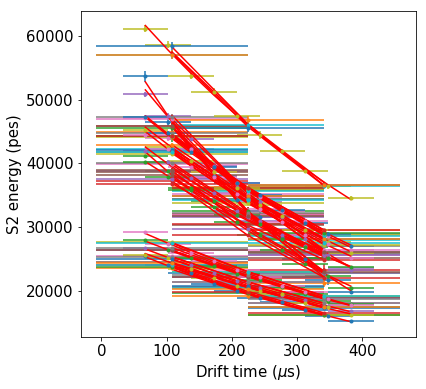

In [48]:
LT  = {}
times = []
times_all = []
lifetimes_all = []
elambdas_all = []
lifetimes = []
timestamp = []

errors = []
for i, run_number in enumerate(runs):
    
    DataPMT = load_db.DataPMT(run_number)
    DataSiPM = load_db.DataSiPM(run_number)
    xs = DataSiPM.X.values
    ys = DataSiPM.Y.values
    
    ifile = os.path.join('/home/brais/Documents/Next/Alpha/data', '{0}/dst_{0}.root.h5'.format(run_number)) 
    full = load_dst(ifile)
    r = event_rate(full)
    
    st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')
    timestamp.append(full.time[0])
    core = full[full.R < 100]     # Cuts
    zrange =   50, 400            # Cuts
    Erange = 1e+3, 70e3
    nbins = 10
    F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))
    lifetimes.append(-F.values[1])
    errors.    append(F.errors[1])
    
    # This part is a little lazy. But, more or less, TIME[0] refers to start of run, TIME[-1] refers to
    # end of the run, TIME[1] refers to middle of run (since nbins=3)
    CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=core, zrange=(50,400), Erange=(1e+3, 80e3), nbins=3)    
    times.append(TIME[1])
times = np.array(times)
lifetimes = np.array(lifetimes)
errors = np.array(errors)


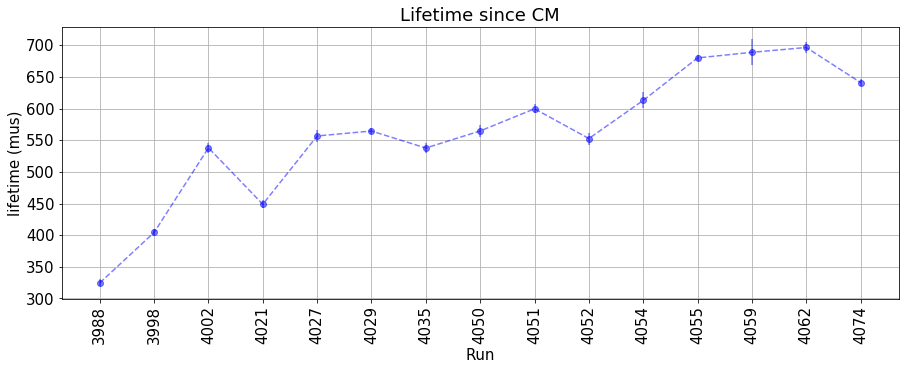

In [49]:
plt.figure(figsize=(15,5))
#plt.plot(times, lifetimes)
plt.errorbar(range(len(lifetimes)), lifetimes, yerr=errors, linestyle='--', fmt='o', c='blue', alpha=.5)
plt.xticks(range(len(lifetimes)), runs, rotation='vertical')
plt.grid(True)
plt.title('Lifetime since CM')
plt.xlabel('Run')
plt.ylabel('lifetime (mus)')
plt.show()



In [50]:
list(zip(runs, times, lifetimes))

[(3988, datetime.datetime(2017, 5, 16, 16, 20, 6), 324.59538338562027),
 (3998, datetime.datetime(2017, 5, 18, 9, 24, 46), 404.24495666252454),
 (4002, datetime.datetime(2017, 5, 18, 11, 52, 50), 537.97792931079141),
 (4021, datetime.datetime(2017, 5, 18, 20, 44, 38), 448.83467263907556),
 (4027, datetime.datetime(2017, 5, 19, 11, 2, 5), 556.71275204870278),
 (4029, datetime.datetime(2017, 5, 19, 21, 50, 49), 564.52377740093323),
 (4035, datetime.datetime(2017, 5, 20, 12, 54, 28), 537.6680686186894),
 (4050, datetime.datetime(2017, 5, 21, 0, 25, 11), 564.66179776067008),
 (4051, datetime.datetime(2017, 5, 21, 12, 58, 38), 599.60725061289725),
 (4052, datetime.datetime(2017, 5, 21, 21, 32, 7), 552.66614970951889),
 (4054, datetime.datetime(2017, 5, 22, 11, 9, 13), 612.93652950513922),
 (4055, datetime.datetime(2017, 5, 22, 21, 36, 56), 679.99603156630121),
 (4059, datetime.datetime(2017, 5, 23, 11, 1, 37), 688.8455957924931),
 (4062, datetime.datetime(2017, 5, 23, 17, 16, 26), 696.45223

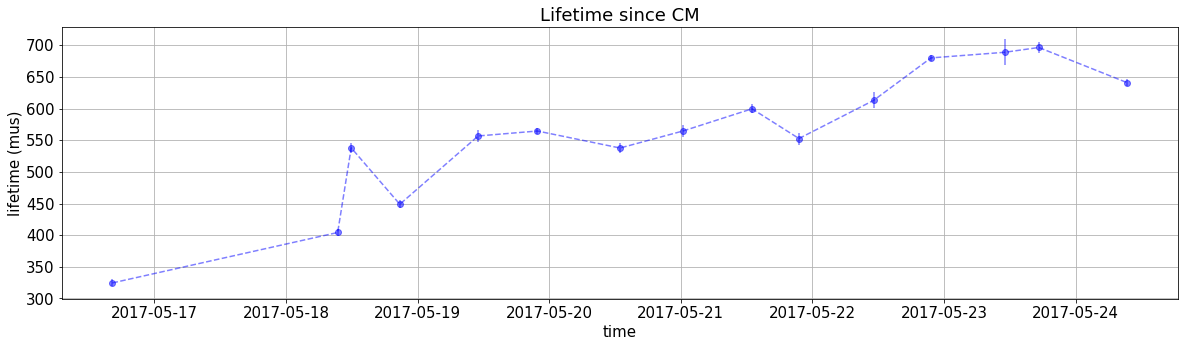

In [51]:
plt.figure(figsize=(20,5))
#plt.plot(times, lifetimes)
plt.errorbar(times, lifetimes, yerr=errors, linestyle='--', fmt='o', c='blue', alpha=.5)
plt.grid(True)
plt.title('Lifetime since CM')
plt.xlabel('time')
plt.ylabel('lifetime (mus)')
plt.show()


In [52]:
errors


array([  5.56803161,   6.23515846,   7.62450068,   6.16327547,
        10.19182985,   4.0780064 ,   8.27618075,   9.75576244,
         7.12755768,   9.4570424 ,  12.72549722,   5.29102523,
        20.4569329 ,   8.05596304,   6.09147898])

In [53]:
timestamp

[1494938995.642,
 1495090771.007,
 1495100812.9549999,
 1495130594.4750001,
 1495184193.4750001,
 1495221271.5450001,
 1495275426.859,
 1495317309.809,
 1495362000.4190001,
 1495392813.332,
 1495443303.825,
 1495476276.428,
 1495529671.013,
 1495549466.6760001,
 1495607923.8150001]